In [1]:
import  os, sys
import  matplotlib.pyplot as plt
import yaml
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
sys.path.append('../')  # Add parent dir to path

import hardware

In [2]:
def mjd_to_hours(mjd):
    mjd_epoch = 2400000.5  # JD of MJD
    
    # MJD --> JD
    jd = mjd + mjd_epoch
    
    # JD --> hrs since start
    hours_since_start = (jd - jd.iloc[0]) * 24

    return hours_since_start

def cart_to_alt_az(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    # az in rad
    theta = np.arctan2(y, x)  # arctan2 handles the correct quadrant of the angle
    # pol angle
    phi = np.arccos(z / r)
    # polar angle to altitude in degrees
    alt = np.degrees(np.pi/2 - phi)  # pi/2 - phi to convert polar angle to altitude
    # az to deg
    az = np.degrees(theta)
    return alt, az


In [3]:
config = yaml.safe_load(open('../config/devices.yml','r'))
config = config['battery']
config['initial']=config['capacity']*0.99 # start with full 
print(config)

{'initial': 238.58010000000002, 'capacity': 240.99, 'charge_unit': 'Ah', 'capacity_fade': 0.0063, 'self_discharge': 0.01, 'VOC_table': 'data/hardware/battery/battery_VOC.dat', 'VOC_table_cols': 'SOC VOC@0 R@0 VOC@20 R@20 VOC@40 R@40'}


## Compare with new model (Night1) 7/24/24

In [4]:
night1_coldpow = pd.read_csv('Night1_Cold Power_354hrEclipse_July25_240730.csv',delimiter=',', header= None)
night1_coldpow = night1_coldpow.T ## flips
night1_coldpow.columns = night1_coldpow.iloc[0] ## sets col
night1_coldpow = night1_coldpow.drop(0) ## reindex
night1_coldpow = night1_coldpow[0:2362] ## end of data
night1_coldpow['tot_sum'] = night1_coldpow['LuSEE Q Total_SUM'].astype(float) + night1_coldpow['POHTR_BATT'].astype(float) + night1_coldpow['Radio_XMIT'].astype(float) 
night1_coldpow=night1_coldpow.loc[:, ~night1_coldpow.columns.duplicated()] ## remove duplicate columns
night1_coldpow['Nodes/Times'] = night1_coldpow['Nodes/Times'].astype(float)
night1_coldpow['Battery_AVG']= night1_coldpow['Battery_AVG'].astype(float)

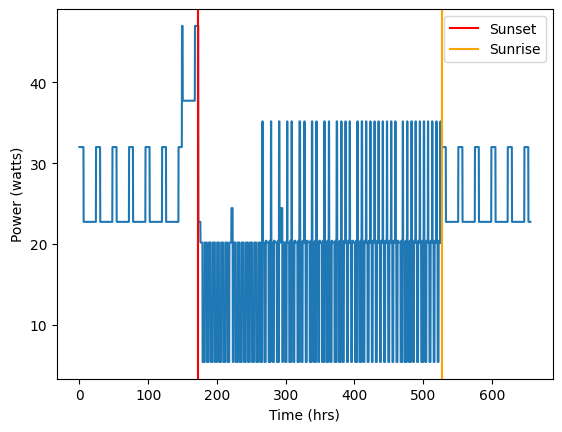

In [5]:
plt.plot(night1_coldpow['Nodes/Times'], night1_coldpow['tot_sum'])
plt.xlabel('Time (hrs)')
plt.ylabel('Power (watts)')
plt.axvline(x = 172.7, color = 'red',label='Sunset')
plt.axvline(x = 527.2, color = 'orange',label='Sunrise')
plt.legend()

Text(0.5, 0, 'Time (hrs)')

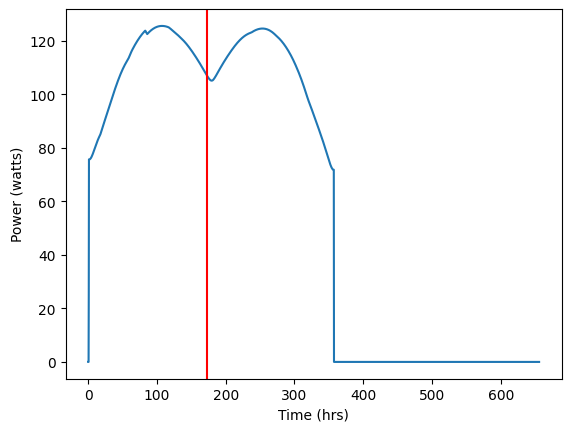

In [14]:
# load in solar panels
sol_pvt = pd.read_csv('sol_pow_RevA.csv',delimiter=',') ## loading in solar power data
sol_pvt['sol_hrs'] = mjd_to_hours(sol_pvt['Time (mjd)'])
sol_pvt= sol_pvt[sol_pvt['sol_hrs'] < max(night1_coldpow['Nodes/Times'])]
sol_pvt['alt'],sol_pvt['az']= cart_to_alt_az(sol_pvt['Solar X'], sol_pvt['Solar Y'], sol_pvt['Solar Z'])

# make interp1d df of sol_pow using thermal time
interp_func = interp1d(sol_pvt['sol_hrs'], sol_pvt['Solar power (watts)'], fill_value='extrapolate')
solpow_interp = interp_func(pd.to_numeric(night1_coldpow['Nodes/Times']))
dict = {'Nodes/Times': night1_coldpow['Nodes/Times'], 'sol_pow_interp':solpow_interp}
interp_sol_pvt = pd.DataFrame.from_dict(dict)

plt.plot(interp_sol_pvt['Nodes/Times'],interp_sol_pvt['sol_pow_interp'])
plt.axvline(x = 172.7, color = 'red',label='Sunset')
plt.ylabel('Power (watts)')
plt.xlabel('Time (hrs)')


In [7]:
sunset = 172.777778
sunrise = 527.222222

## find the index of sunset
night1_coldpow['Nodes/Times_rounded'] = night1_coldpow['Nodes/Times'].round(6)
sunset_rounded = round(sunset, 6)
index_sunset = night1_coldpow[night1_coldpow['Nodes/Times_rounded'] == sunset_rounded].index
index_sunset = index_sunset.tolist()[0]

In [8]:
################ begin at sunset  ##################################
#night1_coldpow = night1_coldpow[night1_coldpow['Nodes/Times'] > sunset] ## cuts to be only running the night portion

In [9]:
colors = ['b','g','k']
T= 0
plt.figure()
B = hardware.Battery(config, verbose=False)
B.set_temperature(T)
deltaT_list= []
soc_values = []
power_values = []
time_list = []
solar_applied = False
solar_index = 0 
sol_cont = []
sunrise_index = None
sunrise_soc = None
solar_index = index_sunset

for i in range(len(night1_coldpow['Nodes/Times']) - 1):
    deltaT =  3600*(night1_coldpow['Nodes/Times'].iloc[i+1] -night1_coldpow['Nodes/Times'].iloc[i])
    deltaT_list.append(deltaT)
    P = night1_coldpow['tot_sum'].iloc[i] 

    if (night1_coldpow['Nodes/Times'].iloc[i] <= sunset):
        ### charging during the day
        P_add = interp_sol_pvt['sol_pow_interp'].iloc[solar_index] ## begin at sunset index
        B.apply_power(P_add, deltaT)
        solar_index += 1
        sol_cont.append(P_add)
    
        ### discharging
        B.apply_power(-P, deltaT)
        B.apply_age(deltaT)
        power_values.append(P)
        soc_values.append(B.SOC())
        
    if  night1_coldpow['Nodes/Times'].iloc[i] > sunset and night1_coldpow['Nodes/Times'].iloc[i] < sunrise:
        sol_cont.append(0)
        ### discharging
        B.apply_power(-P, deltaT)
        B.apply_age(deltaT)
        power_values.append(P)
        soc_values.append(B.SOC())
        sunrise_index = 0
        solar_index = sunrise_index ## switch to sunrise index

    if night1_coldpow['Nodes/Times'].iloc[i] >= sunrise:
        ### charging during the day
        P_add = interp_sol_pvt['sol_pow_interp'].iloc[solar_index]
        B.apply_power(P_add, deltaT)
        solar_index += 1
        sol_cont.append(P_add)

        ## discharging: 
        B.apply_power(-P, deltaT)
        B.apply_age(deltaT)
        power_values.append(P)
        soc_values.append(B.SOC())


<Figure size 640x480 with 0 Axes>

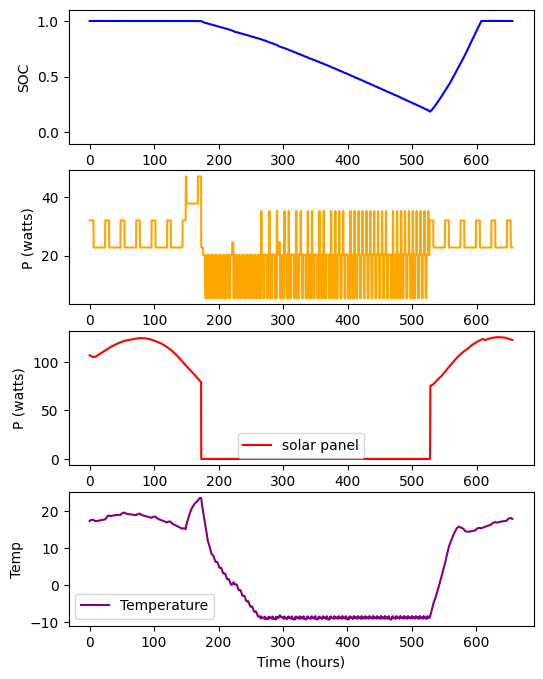

In [10]:
fig =plt.figure(figsize=(6, 8))
plt.subplot(4, 1, 1)
plt.plot(night1_coldpow['Nodes/Times'][:-1], soc_values, color ='blue' ,label=T)
plt.ylim(-0.1,1.1)
plt.ylabel('SOC')
plt.subplot(4, 1, 2)
plt.plot(night1_coldpow['Nodes/Times'][:-1],power_values, color = 'orange' ,label=T )
plt.ylabel('P (watts)')
plt.subplot(4, 1, 3)
plt.plot(night1_coldpow['Nodes/Times'][:-1], sol_cont, color = 'red',label='solar panel')
plt.ylabel('P (watts)')
plt.legend()
plt.subplot(4, 1, 4)
plt.plot(night1_coldpow['Nodes/Times'],night1_coldpow['Battery_AVG'], color = 'purple',label='Temperature')
plt.ylabel('Temp')
plt.xlabel('Time (hours)')
plt.legend()

 
plt.show() 

# Saving Files

In [11]:
## IF wanting to save file locally
csv1 = {'Time_therm':night1_coldpow['Nodes/Times'][:-1], 'SOC':soc_values,'Power_hardware':power_values,'Power_sol_pan':sol_cont,
        'Temperature':night1_coldpow['Battery_AVG'][:-1]}
df = pd.DataFrame.from_dict(csv1)
print('Min soc is:', min(soc_values))
print('End of night, day begins')
print(df[1897:1901])
print('Day ends, night begins')
print(df[620:624])
#pd.DataFrame.to_csv(df,'Night1_t_soc_RevB.csv')

Min soc is: 0.1866442277069804
End of night, day begins
      Time_therm       SOC  Power_hardware  Power_sol_pan  Temperature
1898  526.944444  0.191069           20.18            0.0        -8.92
1899  527.222222  0.189699           32.00            0.0        -8.90
1900  527.500000  0.188329           32.00            0.0        -8.81
1901  527.777778  0.186959           32.00            0.0        -8.68
Day ends, night begins
     Time_therm       SOC  Power_hardware  Power_sol_pan  Temperature
621  172.222222  0.998373           47.00      79.440488        23.52
622  172.500000  0.998373           47.00      79.209851        23.52
623  172.777778  0.998373           47.00      78.978429        23.51
624  173.055556  0.997584           22.74       0.000000        23.42


In [12]:
## IF wanting to save file locally
csv2 = {'Time_opsim':sol_pvt['sol_hrs'],'Solar power (watts)': sol_pvt['Solar power (watts)'],'Solar X':sol_pvt['Solar X'], 'Solar Y':sol_pvt['Solar Y'],'Solar Z':sol_pvt['Solar Z'], 'Panel E Temp': sol_pvt['Panel E Temp'], 'Panel W Temp': sol_pvt['Panel W Temp'],
          'Panel Top Temp': sol_pvt['Panel Top Temp'],'Panel E Efficiency':sol_pvt['Panel E Efficiency'],'Panel W Efficiency':sol_pvt['Panel W Efficiency'], 'Panel Top Efficiency':sol_pvt['Panel Top Efficiency']}  
df = pd.DataFrame.from_dict(csv2)

#pd.DataFrame.to_csv(df,'Night1_xyz_panelT_pveff.csv') ## change file name if desired